In [1]:
# import libraries
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt
from icecube import icetray, dataclasses, dataio, recclasses

# import dictionary
# file provided by Jaun-Carlos (plus printing the keys for easy view)
# Load in the data file (contains SYBILL 2.3d data)
d = np.load("/data/user/juancarlos/notebooks/dst_20904_v3.npz")

#print(list(d.keys()))

In [3]:
# set up quality cut for professional data
qual_cut = (d['zenith'] > 0.002) * (d['zenith'] < (np.pi - 0.002)) * (d['nchannel'] >= 10) * (d['mc_energy'] == d['mc_energy']) * (d['rlogl'] < 25)
# set up bin cut
bin_cut = (d['reco_energy'] > 4) * (d['reco_energy'] < 8)

In [ ]:
# functions to calculate Z value per event, save to array, then take the log10 of the array.
#define a function to go from PDG code to Z
def _get_charge(ptype):
    if ptype<1000020040:
        return 1
    else:
        remainder = int(ptype)%1000000000
        remainder -= remainder%1000
        
        return remainder/10000
    
#turn it into a vectorized function (for speed)
get_charge = np.vectorize(_get_charge)

#example of usage
zarray = get_charge(d['type'])

# create log10(z) array for later cells
lza = np.log10(zarray)

In [ ]:
# Calculate IceCube rigidity - mc_energy is not in log10
ic_rigidity = np.log10(d['mc_energy']) - 3
for comp, comp_cut in IC_COMPS.items():
    ic_rigidity[comp_cut] -= np.log10(Z[comp])

# Calculate median rigidity - note BINS are the IceCube BINS and comes from reco_energy.ipynb
ic_median_rigidity = []
for cut in BINS.values():
    combined_cut = cut * qual_cut
    
    ic_median_rigidity.append(weighted_quantiles(ic_rigidity[combined_cut], d['GlobalSplineFit5Comp'][combined_cut]))

In [45]:
# set up dictionaries for later cells
BINS={
'4.125': (d['reco_energy'] > 4) * (d['reco_energy'] < 4.25),
'4.375': (d['reco_energy'] > 4.25) * (d['reco_energy'] < 4.5),
'4.625': (d['reco_energy'] > 4.5) * (d['reco_energy'] < 4.75),
'4.875': (d['reco_energy'] > 4.75) * (d['reco_energy'] < 5),
'5.125': (d['reco_energy'] > 5) * (d['reco_energy'] < 5.25),
'5.375': (d['reco_energy'] > 5.25) * (d['reco_energy'] < 5.5),
'5.75': (d['reco_energy'] > 5.5) * (d['reco_energy'] < 6),
'6.25': (d['reco_energy'] > 6) * (d['reco_energy'] < 6.5), 
'7.25': (d['reco_energy'] > 6.5) * (d['reco_energy'] < 8)
}
CCUT={
    'proton': d['type'] == 2212,
    'helium': d['type'] == 1.00002004e+09,
    'nitrogen': d['type'] == 1.000070140e+09,
    'aluminum': d['type'] == 1.00013027e+09,
    'iron': d['type'] == 1.00026056e+09
}
Z = {
    'proton': 1,
    'helium': 2,
    'nitrogen': 7,
    'oxygen': 8,
    'aluminum': 13,
    'iron': 26
}

# set up compositional cuts to separate data by composition
pcut = d['type'] == 2212
Hecut = d['type'] == 1.00002004e+09
Ncut = d['type'] == 1.000070140e+09
Alcut = d['type'] == 1.00013027e+09
Fecut =  d['type'] == 1.00026056e+09

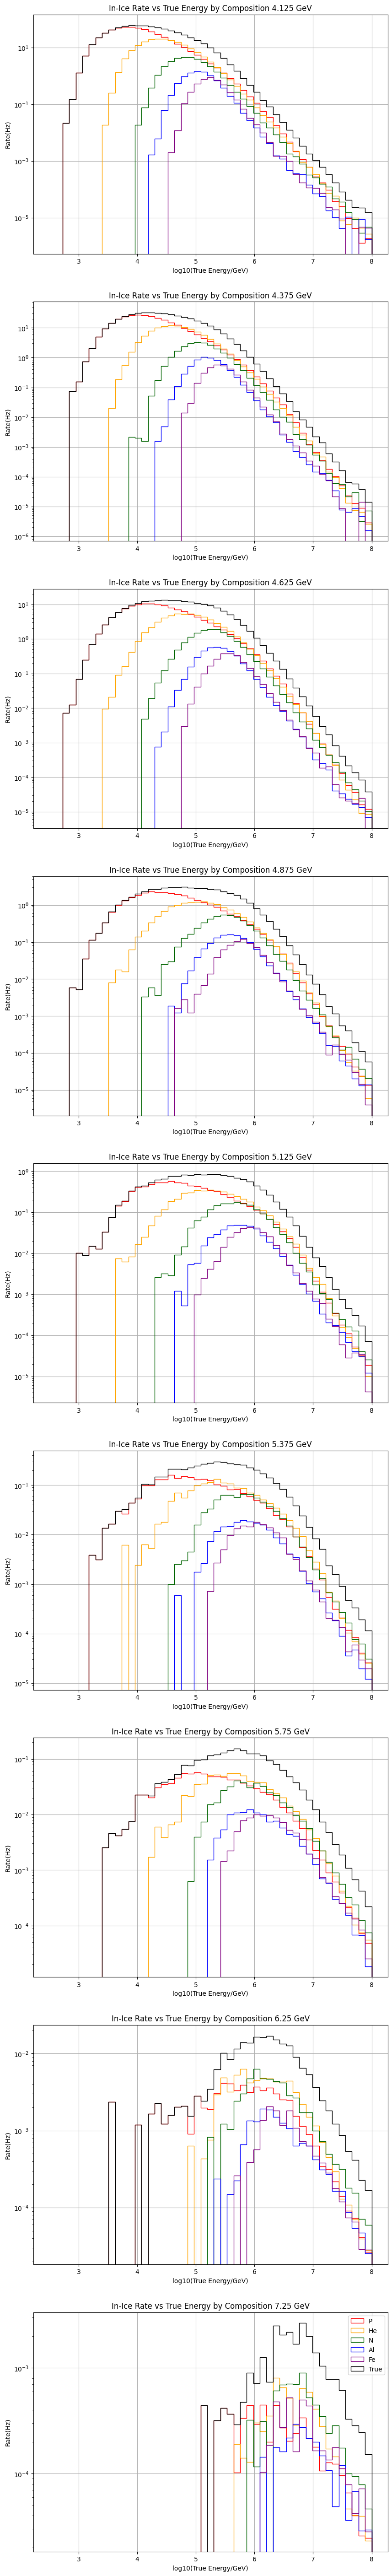

In [47]:
# Cell to plot compositional energy distributions for each energy bin for In-Ice
ncols = 1
nrows = 9
fig, axs = plt.subplots(figsize = (10 * ncols, 8 * nrows), nrows=nrows)
bins=np.linspace(2.5, 8, 50)
k = 0
for i in BINS:
    [pG_i, binpg_i, ppg_i] = axs[k].hist(np.log10(d['mc_energy'][BINS[i] * pcut * qual_cut]), bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][BINS[i] * pcut * qual_cut], color = 'red', histtype = 'step', label = 'P', density=False)
    [HeG_i, binhg_i, phg_i] =axs[k].hist(np.log10(d['mc_energy'][BINS[i] * Hecut * qual_cut]), bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][BINS[i] * Hecut * qual_cut], color = 'orange', histtype = 'step', label = 'He', density=False)
    [NG_i, binng_i, png_i] = axs[k].hist(np.log10(d['mc_energy'][BINS[i] * Ncut * qual_cut]), bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][BINS[i] * Ncut * qual_cut], color = 'darkgreen', histtype = 'step', label = 'N', density=False)
    [AlG_i, binag_i, pag_i] = axs[k].hist(np.log10(d['mc_energy'][BINS[i] * Alcut * qual_cut]), bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][BINS[i] * Alcut * qual_cut], color = 'blue', histtype = 'step', label = 'Al', density=False)
    [FeG_i, binfg_i, pfg_i] = axs[k].hist(np.log10(d['mc_energy'][BINS[i] * Fecut * qual_cut]), bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][BINS[i] * Fecut * qual_cut], color = 'purple', histtype = 'step', label = 'Fe', density=False)
    [TG_i, bintg_i, ptg_i] = axs[k].hist(np.log10(d['mc_energy'][BINS[i] * qual_cut]), bins = bins, log=True, weights = d['GlobalSplineFit5Comp'][BINS[i] * qual_cut], color = 'black', histtype = 'step', label = 'True', density=False)
    axs[k].set_xlabel('log10(True Energy/GeV)')
    axs[k].set_ylabel('Rate(Hz)')
    axs[k].set_title('In-Ice Rate vs True Energy by Composition ' + str(i) + ' GeV')
    #axs[k].set_ylim(1e-5, 1e2)
    axs[k].grid()
    k += 1
plt.legend()

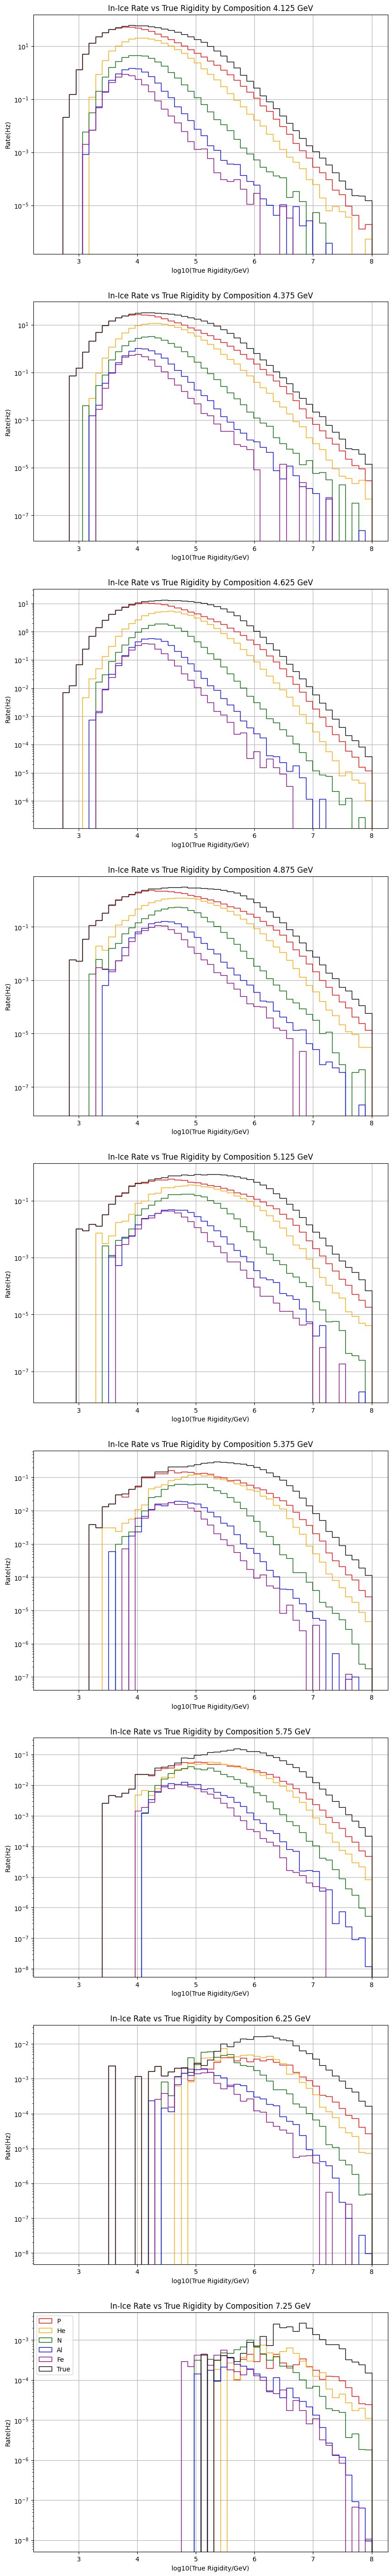

In [44]:
# Cell to plot compositional energy distributions for each energy bin for In-Ice
ncols = 1
nrows = 9
fig, axs = plt.subplots(figsize = (10 * ncols, 8 * nrows), nrows=nrows)
bins=np.linspace(2.5, 8, 50)
k = 0
for i in BINS:
    [pG_i, binpg_i, ppg_i] = axs[k].hist(np.log10(d['mc_energy'][BINS[i] * pcut * qual_cut]/1), bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][BINS[i] * pcut * qual_cut], color = 'red', histtype = 'step', label = 'P', density=False)
    [HeG_i, binhg_i, phg_i] =axs[k].hist(np.log10(d['mc_energy'][BINS[i] * Hecut * qual_cut]/2), bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][BINS[i] * Hecut * qual_cut], color = 'orange', histtype = 'step', label = 'He', density=False)
    [NG_i, binng_i, png_i] = axs[k].hist(np.log10(d['mc_energy'][BINS[i] * Ncut * qual_cut]/7), bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][BINS[i] * Ncut * qual_cut], color = 'darkgreen', histtype = 'step', label = 'N', density=False)
    [AlG_i, binag_i, pag_i] = axs[k].hist(np.log10(d['mc_energy'][BINS[i] * Alcut * qual_cut]/13), bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][BINS[i] * Alcut * qual_cut], color = 'blue', histtype = 'step', label = 'Al', density=False)
    [FeG_i, binfg_i, pfg_i] = axs[k].hist(np.log10(d['mc_energy'][BINS[i] * Fecut * qual_cut]/26), bins = bins, log = True, weights=d['GlobalSplineFit5Comp'][BINS[i] * Fecut * qual_cut], color = 'purple', histtype = 'step', label = 'Fe', density=False)
    [TG_i, bintg_i, ptg_i] = axs[k].hist(np.log10(d['mc_energy'][BINS[i] * qual_cut]), bins = bins, log=True, weights = d['GlobalSplineFit5Comp'][BINS[i] * qual_cut], color = 'black', histtype = 'step', label = 'True', density=False)
    axs[k].set_xlabel('log10(True Rigidity/GeV)')
    axs[k].set_ylabel('Rate(Hz)')
    axs[k].set_title('In-Ice Rate vs True Rigidity by Composition ' + str(i) + ' GeV')
    #axs[k].set_ylim(1e-5, 1e2)
    axs[k].grid()
    k += 1
plt.legend()